## Image dataset: dog breeds 
#### http://vision.stanford.edu/aditya86/ImageNetDogs/

In [2]:
# dataset path
import os
path = f"{os.getcwd()}\Images"
print(path)

C:\Users\Ephraim\UEL\summative assignment\Images


## Restructure Image Folder
1. Move breed images to a new folder. e.g. n0129xx-dog_breed_name will be moved to dog_breed_name
2. Each image in the folder will be renamed to breed_name_[index] .. eg. dog_breed_name_1.jpg
3. Remove empty folders

In [3]:
from typing import Union

def move_images_to_new_folder(root_path: Union[str, int]) -> None:
    for folder in os.listdir(root_path):
        if folder.startswith("n0"):
            try:
                breed_name: str = folder[folder.index('-'):].replace('-', '')
                image_path: str = f"{path}/{folder}"
                # create a new path to host the images
                new_image_path = f"{path}/{breed_name}"
                if not os.path.exists(new_image_path):
                    os.makedirs(new_image_path)
                for index, file in enumerate(os.listdir(image_path)):
                    image_extension = file[file.index("."):]
                    # rename images: e.g. breed_name_1.jpg
                    new_image_name: str = f"{breed_name}_{index}{image_extension}"
                    if file != new_image_name:
                        old_path = f"{image_path}/{file}"
                        new_path = f"{new_image_path}/{new_image_name}"
                        os.rename(old_path,new_path)
                        print(f"moved {file} to {new_path}")
                # remove old image folder
                os.rmdir(image_path)
            except ValueError:
                pass
            
move_images_to_new_folder(path)

## Randomly Pick Two Working Folders
1. Randomly Picks to folders to work with
2. Deletes Other Folders

In [5]:
import shutil
import random
from typing import List

def randomly_pick_working_dirs(root_path: str) -> List[str]:
    folders = os.listdir(root_path)
    if len(folders) == 2:
        return folders
    
    working_dirs = []
    for _ in range(2):
        index = random.randrange(0, len(folders))
        if folders[index] not in working_dirs:
             working_dirs.append(folders[index])           
        
    for folder in list(set(folders) - set(working_dirs)):
        # remove folders that we won't use in the classification
        shutil.rmtree(f"{path}/{folder}/")
    return working_dirs

folders = randomly_pick_working_dirs(path)
print(folders)

['Border_terrier', 'Yorkshire_terrier']


## Data Clean Up
- Checks for corrupt images
- Deletes any corrupt image found

In [6]:
import tensorflow as tf

def image_cleanup(root_path: str) -> None:
    num_skipped = 0
    for folder in os.listdir(root_path):
        image_path = os.path.join(root_path, folder)
        for image in os.listdir(image_path):
            image_file_path = os.path.join(image_path,image)
            is_jfif = True
            with open(image_file_path, "rb") as f:
                is_jfif = tf.compat.as_bytes("JFIF") in f.peek(10)
                f.close()
                
            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(image_file_path)                
                  

    print(f"{num_skipped} images deleted")
    
image_cleanup(path)

0 images deleted


## Create a folder Map
This is a "helper" dictionary that we'll use in identifying classes

In [7]:
def image_dictionary(image_path: str) -> dict:
    return dict(enumerate(os.listdir(image_path)))

data_category_dict = image_dictionary(path)
print(data_category_dict)

{0: 'Border_terrier', 1: 'Yorkshire_terrier'}


## Generate Two Sets of data
1. Training dataset (80%)
2. Validation dataset (20%)

In [8]:
from typing import Tuple

image_size = (180, 180)
batch_size = 32

def generate_dataset(image_path: str, image_size: Tuple, batch_size: int, seed_size: int , subset: str):
    return tf.keras.preprocessing.image_dataset_from_directory(
        image_path,
        validation_split=0.2,
        subset=subset,
        seed=seed_size,
        image_size=image_size,
        batch_size=batch_size,
    )

# Training Data
training_data = generate_dataset(
    subset="training",
    image_path=path,
    image_size=image_size,
    batch_size=batch_size,
    seed_size=1500
)

# validation data
validation_data = generate_dataset(
    subset="validation",
    image_path=path,
    image_size=image_size,
    batch_size=batch_size,
    seed_size=1500
)

Found 336 files belonging to 2 classes.
Using 269 files for training.
Found 336 files belonging to 2 classes.
Using 67 files for validation.


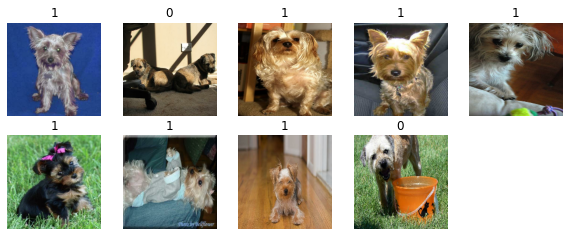

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))      
        plt.axis("off")     


In [10]:
training_data = training_data.prefetch(buffer_size=32)
validation_data = validation_data.prefetch(buffer_size=32)

In [49]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


def image_classification_model(classes: int) -> keras.Model:
    inputs = keras.Input(shape=(180, 180, 3))
    model = data_augmentation(inputs)
    # Entry block
    model = layers.Rescaling(1.0 / 255)(model)
    model = layers.Conv2D(32, 3, strides=2, padding="same")(model)
    model = layers.BatchNormalization()(model)
    model = layers.Activation("relu")(model)

    model = layers.Conv2D(64, 3, padding="same")(model)
    model = layers.BatchNormalization()(model)
    model = layers.Activation("relu")(model)


    model = layers.SeparableConv2D(1024, 3, padding="same")(model)
    model = layers.BatchNormalization()(model)
    model = layers.Activation("relu")(model)

    model = layers.GlobalAveragePooling2D()(model)
    if classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = classes

    model = layers.Dropout(0.5)(model)
    outputs = layers.Dense(units, activation=activation)(model)
    return keras.Model(inputs, outputs)


categories = len(next(os.walk(path))[1])
model = image_classification_model(classes=categories)


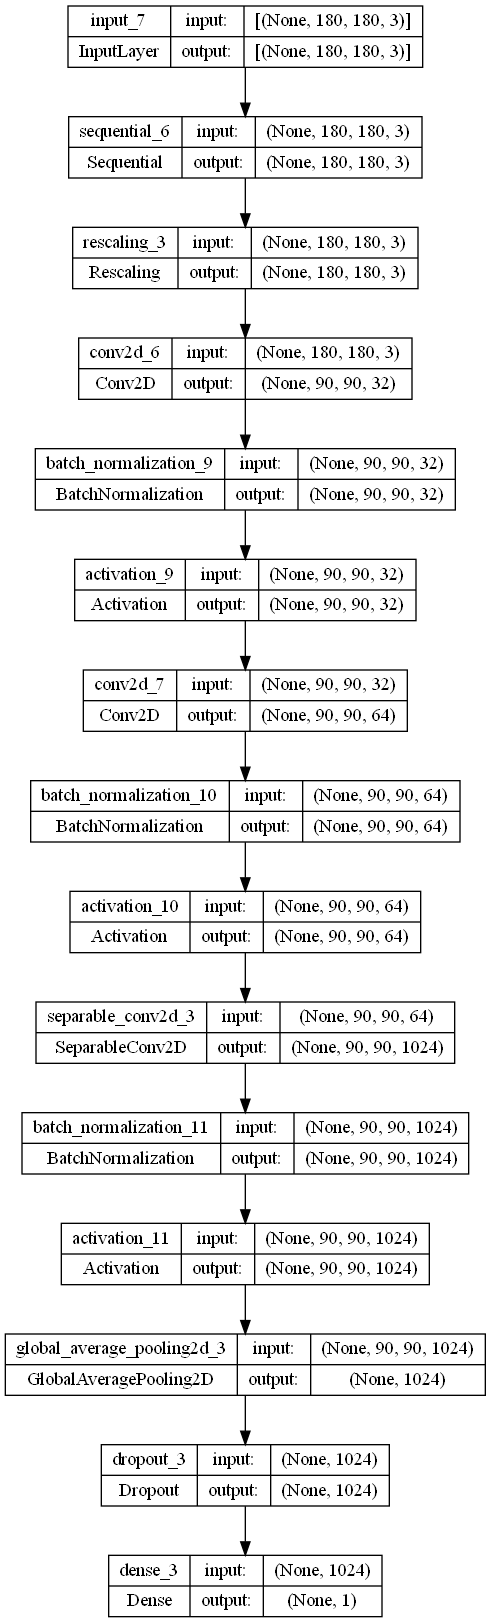

In [50]:
keras.utils.plot_model(model, show_shapes=True)

##Train The Model

In [48]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model = model.fit(
    training_data, epochs=epochs, callbacks=callbacks, validation_data=validation_data,
)

Epoch 1/100
9/9 [==============================] - 42s 4s/step - loss: 0.7583 - accuracy: 0.5204 - val_loss: 0.6951 - val_accuracy: 0.4627
Epoch 2/100
9/9 [==============================] - 40s 4s/step - loss: 0.7199 - accuracy: 0.5725 - val_loss: 0.6941 - val_accuracy: 0.4627
Epoch 3/100
9/9 [==============================] - 39s 4s/step - loss: 0.6669 - accuracy: 0.5985 - val_loss: 0.6945 - val_accuracy: 0.4627
Epoch 4/100
9/9 [==============================] - 39s 4s/step - loss: 0.6408 - accuracy: 0.6283 - val_loss: 0.6931 - val_accuracy: 0.5373
Epoch 5/100
9/9 [==============================] - 40s 4s/step - loss: 0.6412 - accuracy: 0.6468 - val_loss: 0.6939 - val_accuracy: 0.4478
Epoch 6/100
9/9 [==============================] - 39s 4s/step - loss: 0.6529 - accuracy: 0.6394 - val_loss: 0.6934 - val_accuracy: 0.4627
Epoch 7/100
9/9 [==============================] - 39s 4s/step - loss: 0.6539 - accuracy: 0.6468 - val_loss: 0.6942 - val_accuracy: 0.3731
Epoch 8/100
9/9 [==========

9/9 [==============================] - 39s 4s/step - loss: 0.5129 - accuracy: 0.7584 - val_loss: 0.5732 - val_accuracy: 0.6716
Epoch 60/100
9/9 [==============================] - 40s 4s/step - loss: 0.5147 - accuracy: 0.7398 - val_loss: 0.5737 - val_accuracy: 0.7313
Epoch 61/100
9/9 [==============================] - 40s 4s/step - loss: 0.5326 - accuracy: 0.7361 - val_loss: 0.5565 - val_accuracy: 0.7015
Epoch 62/100
9/9 [==============================] - 40s 4s/step - loss: 0.5066 - accuracy: 0.7286 - val_loss: 0.5670 - val_accuracy: 0.7164
Epoch 63/100
9/9 [==============================] - 39s 4s/step - loss: 0.5052 - accuracy: 0.7658 - val_loss: 0.5686 - val_accuracy: 0.6716
Epoch 64/100
9/9 [==============================] - 40s 4s/step - loss: 0.4860 - accuracy: 0.7695 - val_loss: 0.5593 - val_accuracy: 0.7463
Epoch 65/100
9/9 [==============================] - 40s 4s/step - loss: 0.4870 - accuracy: 0.7621 - val_loss: 0.5679 - val_accuracy: 0.7015
Epoch 66/100
9/9 [===============

TypeError: 'History' object is not subscriptable

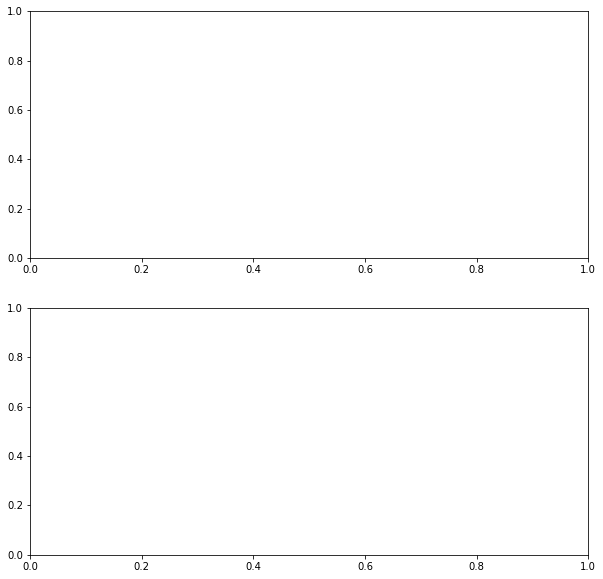

In [53]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.plot(model.history['loss'], color='b', label="Training loss")
ax1.plot(model.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(model.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [51]:
image = tf.keras.preprocessing.image.load_img(
    f"{path}/Border_terrier/Border_terrier_5.jpg", target_size=image_size
)
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

predictions = model.predict(image_array)
score = predictions[0]

Border_terrier = 100 * (1 - score)
Yorkshire_terrier =  100 * score

if Border_terrier_5 > Yorkshire_terrier:
    print(f"Theres is a {Border_terrier}% chance that the dog is a Border Terrier")
    
elif Yorkshire_terrier > Border_terrier:
    print(f"Theres is a {Yorkshire_terrier}% chance that the dog is a Yorkshire Terrier")

1/1 [==============================] - 0s 243ms/step
Theres is a [49.94399]% chance that the dog is a Border Terrier
